In [23]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

%matplotlib inline

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [11]:

conn = sqlite3.connect("../db.sqlite3")

query = """
    SELECT restaurant_product.id, restaurant_product.name, restaurant_product.price, restaurant_order.datetime, restaurant_orderitem.quantity
    FROM restaurant_orderitem
    JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id
    JOIN restaurant_order ON restaurant_orderitem.order_id = restaurant_order.id
"""

restaurant_data = pd.read_sql_query(query, conn)
conn.close()
restaurant_data.to_csv("restaurant.csv", index=False)

df = pd.read_csv("restaurant.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        74818 non-null  int64         
 1   name      74818 non-null  object        
 2   price     74818 non-null  float64       
 3   datetime  74818 non-null  datetime64[ns]
 4   quantity  74818 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 2.9+ MB


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

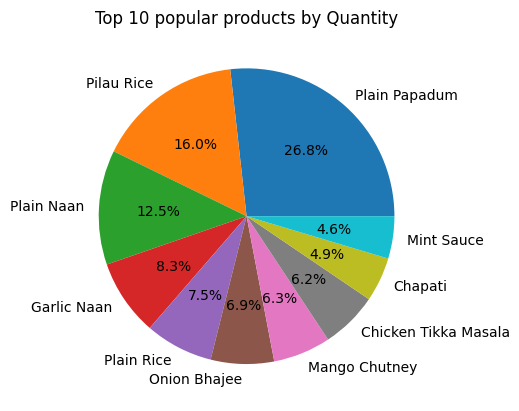

In [34]:
group_by_quantity = df.groupby("name")["quantity"].sum()
sort = group_by_quantity.sort_values(ascending=False)
result_by_quantity = sort[:10]

plt.pie(result_by_quantity.values, labels=result_by_quantity.index, autopct="%1.1f%%")
plt.title("Top 10 popular products by Quantity")
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

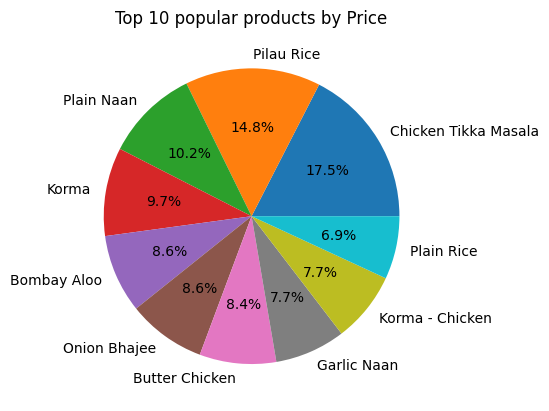

In [36]:
df["Item Price"] = df["price"] * df["quantity"]
group_by_price = df.groupby("name")["Item Price"].sum()
sort_by_price = group_by_price.sort_values(ascending=False)
result_by_price = sort_by_price[:10]
plt.pie(result_by_price.values, labels=result_by_price.index, autopct="%1.1f%%")
plt.title("Top 10 popular products by Price")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

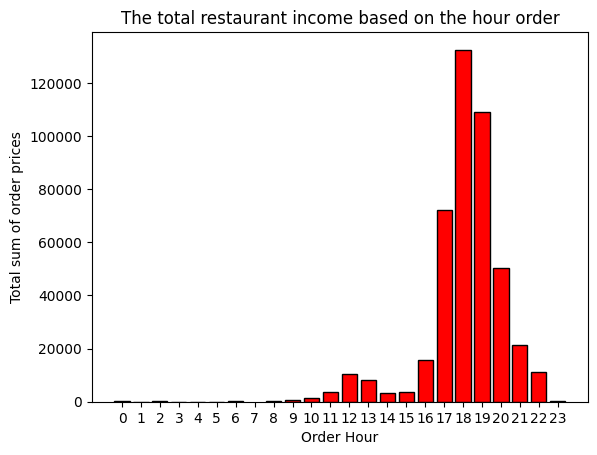

In [53]:
df["Order Hour"] = df["datetime"].dt.hour
result_by_hour = df.groupby("Order Hour")["Item Price"].sum()

plt.bar(result_by_hour.index, result_by_hour.values, color="red", edgecolor="black")
plt.title("The total restaurant income based on the hour order")
plt.xlabel("Order Hour")
plt.ylabel("Total sum of order prices")
plt.xticks(range(len(result_by_hour.index) + 1))
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

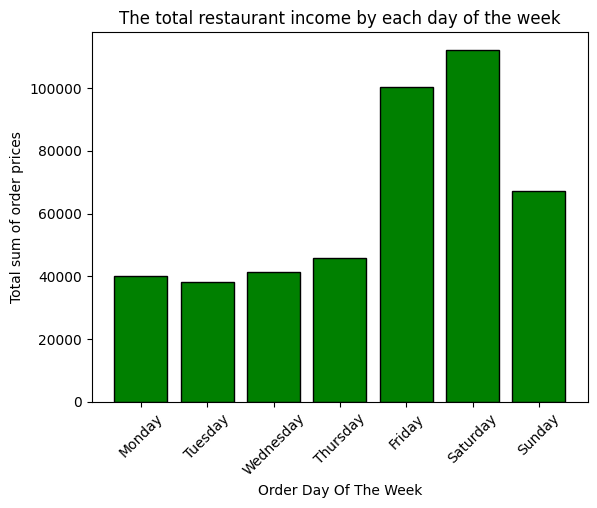

In [61]:
df["Order Day"] = df["datetime"].dt.strftime('%A')
result_by_day = df.groupby("Order Day")["Item Price"].sum()
weekdays_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
result_by_day = result_by_day.reindex(weekdays_order)

plt.bar(result_by_day.index, result_by_day.values, color="green", edgecolor="black")
plt.title("The total restaurant income by each day of the week")
plt.xlabel("Order Day Of The Week")
plt.ylabel("Total sum of order prices")
plt.xticks(rotation=45)
plt.show()